In [ ]:

#%% import needed packages
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
tf.compat.v1.disable_eager_execution() #para ser compatibles con la versión1
import random
random.seed(0)


import plotly.graph_objects as go
import plotly.express as px
import scipy.special as sc
from matplotlib.animation import FuncAnimation


import warnings
warnings.filterwarnings("ignore")
import heapq

# Heat Equations 2D

## DGM 2D

### Arquitectura

In [ ]:
# CLASS DEFINITIONS FOR NEURAL NETWORKS USED IN DEEP GALERKIN METHOD


#%% LSTM-like layer used in DGM (see Figure 5.3 and set of equations on p. 45) - modification of Keras layer class

class LSTMLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, trans1 = "sigmoid", trans2 = "sigmoid"):
        '''
        Args:
            input_dim (int):       dimensionality of input data
            output_dim (int):      number of outputs for LSTM layers
            trans1, trans2 (str):  activation functions used inside the layer; 
                                   one of: "tanh" (default), "relu" or "sigmoid"
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of LSTMLayer)
        super(LSTMLayer, self).__init__()
        
        # add properties for layer including activation functions used inside the layer  
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid
        
        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.relu
        
        ### define LSTM layer parameters (use Xavier initialization)
        # u vectors (weighting vectors for inputs original inputs x)
        self.Uz = self.add_variable("Uz", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Ug = self.add_variable("Ug", shape=[self.input_dim ,self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Ur = self.add_variable("Ur", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Uh = self.add_variable("Uh", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        
        # w vectors (weighting vectors for output of previous layer)        
        self.Wz = self.add_variable("Wz", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Wg = self.add_variable("Wg", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Wr = self.add_variable("Wr", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Wh = self.add_variable("Wh", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        
        # bias vectors
        self.bz = self.add_variable("bz", shape=[1, self.output_dim])
        self.bg = self.add_variable("bg", shape=[1, self.output_dim])
        self.br = self.add_variable("br", shape=[1, self.output_dim])
        self.bh = self.add_variable("bh", shape=[1, self.output_dim])
    
    
    # main function to be called 
    def call(self, S, X):
        '''Compute output of a LSTMLayer for a given inputs S,X .    

        Args:            
            S: output of previous layer
            X: data input
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''   
        
        # compute components of LSTM layer output (note H uses a separate activation function)
        Z = self.trans1(tf.add(tf.add(tf.matmul(X,self.Uz), tf.matmul(S,self.Wz)), self.bz))
        G = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ur), tf.matmul(S, self.Wr)), self.br))
        
        H = self.trans2(tf.add(tf.add(tf.matmul(X,self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        
        # compute LSTM layer output
        S_new = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z,S))
        
        return S_new

#%% Fully connected (dense) layer - modification of Keras layer class
   
class DenseLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, transformation=None):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map 
        
        Returns: customized Keras (fully connected) layer object 
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of DenseLayer)
        super(DenseLayer,self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        self.W = self.add_variable("W", shape=[self.input_dim, self.output_dim],
                                   initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        
        # bias vectors
        self.b = self.add_variable("b", shape=[1, self.output_dim])
        
        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation
    
    
    # main function to be called 
    def call(self,X):
        '''Compute output of a dense layer for a given input X 

        Args:                        
            X: input to layer            
        '''
        
        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W), self.b)
                
        if self.transformation:
            S = self.transformation(S)
        
        return S

#%% Neural network architecture used in DGM - modification of Keras Model class
    
class DGMNet(tf.keras.Model):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, layer_width, n_layers, input_dim, final_trans=None):
        '''
        Args:
            layer_width: 
            n_layers:    number of intermediate LSTM layers
            input_dim:   spaital dimension of input data (EXCLUDES time dimension)
            final_trans: transformation used in final layer
        
        Returns: customized Keras model object representing DGM neural network
        '''  
        
        # create an instance of a Model object (call initialize function of superclass of DGMNet)
        super(DGMNet,self).__init__()
        
        # define initial layer as fully connected 
        # NOTE: to account for time inputs we use input_dim+1 as the input dimensionality
        self.initial_layer = DenseLayer(layer_width, input_dim+1, transformation = "tanh")
        
        # define intermediate LSTM layers
        self.n_layers = n_layers
        self.LSTMLayerList = []
                
        for _ in range(self.n_layers):
            self.LSTMLayerList.append(LSTMLayer(layer_width, input_dim+1))
        
        # define final layer as fully connected with a single output (function value)
        self.final_layer = DenseLayer(1, layer_width, transformation = final_trans)
    
    
    # main function to be called  
    def call(self,t,x1,x2):
        '''            
        Args:
            t: sampled time inputs 
            x: Lista sampled space inputs 

        Run the DGM model and obtain fitted function value at the inputs (t,x)                
        '''  
        
        # define input vector as time-space pairs
        
        X = tf.concat([t,x1,x2],1) #agregar mas variables 
        
        # call initial layer
        S = self.initial_layer.call(X)
        
        # call intermediate LSTM layers
        for i in range(self.n_layers):
            S = self.LSTMLayerList[i].call(S,X)
        
        # call final LSTM layers
        result = self.final_layer.call(S)
        
        return result

### Setup de la ecuación

https://fenicsproject.org/pub/tutorial/html/._ftut1006.html

$\begin{aligned} \frac{\partial u}{\partial t} &=\nabla^{2} u +f& & \text { in } \Omega \times(0, T] \\ u &=u_{\mathrm{D}} & & \text { on } \partial \Omega \times(0, T] \\ u &=u_{0} & & \text { at } t=0 \end{aligned}$

$G(NN(x,t))= \frac{\partial NN}{\partial t} -\nabla^{2} NN +---- +---- $

$f= \beta -2-2\alpha$

$u_D= 1+x^2+\alpha y^2 + \beta t$

$u_0= 1+x^2+\alpha y^2 $

$u=  1+x^2+\alpha y^2 + \beta t$

T= 2

$\Omega= [0,1]^2$


In [ ]:
alpha = 3; beta = 1.2
def solucion_analitica(x1,x2,t,alpha,beta):
  return 1+x1**2+alpha*x2**2+beta*t

def solucion_borde(x1,x2,t,alpha,beta):
  return  1+x1**2+alpha*x2**2+beta*t

def solucion_inical(x1,x2,alpha):
  return  1+x1**2+alpha*x2**2

In [ ]:
T=2
# Solution parameters (domain on which to solve PDE)
t_low = 0 + 1e-10    # time lower bound
S_low = 0.0 + 1e-10  # spot price lower bound
S_high = 1       # spot price upper bound

# neural network parameters
num_layers = 3
nodes_per_layer = 50
learning_rate = 0.001

# Training parameters
sampling_stages  = 50 #50   # number of times to resample new time-space domain points
steps_per_sample = 40 #10    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_interior = 1000
nSim_boundary = 1000
nSim_terminal = 200
S_multiplier  = 1.1   # multiplier for oversampling i.e. draw S from [S_low, S_high * S_multiplier]

# Plot options
n_plot = 70  # Points on plot grid for each dimension

### Muestreo

In [ ]:
def plot_edges(n_points, x_max=1, y_max=1, x_min=0, y_min=0):

    vertical_edge_x = np.random.uniform(x_min, x_max, n_points)
    vertical_edige_y = np.asarray([y_min, y_max])[
        np.random.randint(2, size=n_points)
    ]
    horizontal_edge_x = np.asarray([x_min, x_max])[
        np.random.randint(2, size=n_points)
    ]
    horizontal_edge_y = np.random.uniform(x_min, x_max, n_points)

    x= np.concatenate((vertical_edge_x.reshape(-1,1), vertical_edige_y.reshape(-1,1)), axis=1)
    x_=  np.concatenate((horizontal_edge_x.reshape(-1,1), horizontal_edge_y.reshape(-1,1)), axis=1)
    return np.concatenate((x,x_),axis=0)

In [ ]:

def sampler(nSim_interior,nSim_boundary,nSim_terminal):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at terminal time to sample (terminal condition)
    ''' 
    
    # Sampler #1: domain interior
    t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
    S_interior = np.random.uniform(low=S_low, high=S_high*S_multiplier, size=[nSim_interior, 2])

    # Sampler #2: spatial boundary
        # no spatial boundary condition for this problem
    t_boundary = np.random.uniform(low=t_low, high=T, size=[nSim_boundary, 1])
    S_boundary =plot_edges(int(nSim_boundary/2))
    
    # Sampler #3: initial/terminal condition
    t_terminal = T * np.zeros((nSim_terminal, 1))
    S_terminal = np.random.uniform(low=S_low, high=S_high*S_multiplier, size = [nSim_terminal, 2])
    
    return t_interior, S_interior, t_boundary, S_boundary, t_terminal, S_terminal


#### adaptativo

In [ ]:

def sampler_adaptativo(nSim_interior,nSim_boundary,nSim_terminal,  e_tiempo, e_espacio):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at terminal time to sample (terminal condition)
    ''' 
    if t_low+0.02<e_tiempo<T-0.02 and S_low+0.2<e_espacio<S_high-0.2 :
      print("adap")
      t_interior_1 = np.random.uniform(low=t_low, high=T, size=[int(nSim_interior/2), 1])
      S_interior_1 = np.random.uniform(low=S_low, high=S_high*S_multiplier, size=[int(nSim_interior/2), 2])      
      #error
      t_interior_2= np.random.uniform(low=e_tiempo- 0.01, high=e_tiempo+0.01, size=[int(nSim_interior/2), 1])
      S_interior_2 = np.random.uniform(low=e_espacio -0.1, high=e_espacio+0.1, size=[int(nSim_interior/2), 2])

      t_interior= np.concatenate([t_interior_1,t_interior_2],axis=0)
      S_interior= np.concatenate([S_interior_1,S_interior_2],axis=0)

    else:
      t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
      S_interior = np.random.uniform(low=S_low, high=S_high, size=[nSim_interior, 2])
    
    # Sampler #1: domain interior
    #t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
    #S_interior = np.random.uniform(low=S_low, high=S_high*S_multiplier, size=[nSim_interior, 2])

    # Sampler #2: spatial boundary
        # no spatial boundary condition for this problem
    t_boundary = np.random.uniform(low=t_low, high=T, size=[nSim_boundary, 1])
    S_boundary =plot_edges(int(nSim_boundary/2))
    
    # Sampler #3: initial/terminal condition
    t_terminal = T * np.zeros((nSim_terminal, 1))
    S_terminal = np.random.uniform(low=S_low, high=S_high*S_multiplier, size = [nSim_terminal, 2])
    
    return t_interior, S_interior, t_boundary, S_boundary, t_terminal, S_terminal


### Loss

In [ ]:

#%% Loss function for Fokker-Planck equation

def loss(model, t_interior, S_interior, t_boundary, S_boundary, t_terminal, S_terminal):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        t_interior: sampled time points in the interior of the function's domain
        S_interior: sampled space points in the interior of the function's domain
        t_terminal: sampled time points at terminal point (vector of terminal times)
        S_terminal: sampled space points at terminal time
    ''' 
    
    # Loss term #1: PDE
    # compute function value and derivatives at current sampled points
    x=tf.reshape(S_interior[:,0],[-1,1])
    y= tf.reshape(S_interior[:,1],[-1,1])
    V = model(t_interior, x,y)
    V_t = tf.gradients(ys=V, xs=t_interior)[0]
    V_x = tf.gradients(ys=V, xs=x)[0]
    V_y= tf.gradients(ys=V, xs=y)[0]
    V_xx = tf.gradients(ys=V_x, xs=x)[0]
    V_yy = tf.gradients(ys=V_y, xs=y)[0]
    diff_V = V_t -V_xx-V_yy - (beta-2-2*alpha)

    # compute average L2-norm of differential operator
    L1 = tf.reduce_mean(input_tensor=tf.square(diff_V)) 
    
    # Loss term #2: boundary condition
    x_b=tf.reshape(S_boundary[:,0],[-1,1])
    y_b=tf.reshape(S_boundary[:,1],[-1,1])
    L2= tf.reduce_mean( input_tensor=tf.square(model(t_boundary, x_b,y_b)- (1+x_b**2+alpha*y_b**2 + beta*t_boundary)) )
    
    # Loss term #3: initial/terminal condition
    x_b_t=tf.reshape(S_terminal[:,0],[-1,1])
    y_b_t=tf.reshape(S_terminal[:,0],[-1,1])
    fitted = model(t_terminal, x_b_t,x_b_t) - (1+x_b_t**2+alpha*y_b_t**2 )
    
    L3 = tf.reduce_mean( input_tensor=tf.square(fitted) )

    return tf.square(diff_V),tf.square(model(t_boundary, x_b,y_b)- (1+x_b**2+alpha*y_b**2 + beta*t_boundary)), tf.square(fitted)

### Entrenamiento

In [ ]:
#%% Set up network
X_train=[]
loss_por_batch=[]
# initialize DGM model (last input: space dimension = 1)
model = DGMNet(nodes_per_layer, num_layers, 2)#1

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
S_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None,2])
t_boundary_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
S_boundary_tnsr = tf.compat.v1.placeholder(tf.float32, [None,2])
t_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
S_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None,2])

# loss 
L1_tnsr,L2_tnsr, L3_tnsr = loss(model, t_interior_tnsr, S_interior_tnsr, t_boundary_tnsr,S_boundary_tnsr,t_terminal_tnsr, S_terminal_tnsr)
loss_tnsr =  tf.reduce_mean(L1_tnsr)  +  tf.reduce_mean(L2_tnsr) +  tf.reduce_mean(L3_tnsr) 

# option value function
V = model(t_interior_tnsr, tf.reshape(S_interior_tnsr[:,0],[-1,1]),tf.reshape(S_interior_tnsr[:,1],[-1,1]))

# set optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.compat.v1.global_variables_initializer()

# open session
sess = tf.compat.v1.Session()
sess.run(init_op)

#%% Train network
# for each sampling stage
for i in range(sampling_stages):
    
    # sample uniformly from the required regions
    t_interior, S_interior, t_boundary, S_boundary, t_terminal, S_terminal =sampler(nSim_interior,nSim_boundary, nSim_terminal)
    X_train.append([t_interior, S_interior, t_boundary, S_boundary, t_terminal, S_terminal])
    # for a given sample, take the required number of SGD steps
    for _ in range(steps_per_sample):
        loss,L1,L2,L3,_ = sess.run([loss_tnsr, L1_tnsr, L2_tnsr,L3_tnsr, optimizer],
                                 feed_dict = {t_interior_tnsr:t_interior, S_interior_tnsr:S_interior,t_boundary_tnsr:t_boundary, S_boundary_tnsr:S_boundary, t_terminal_tnsr:t_terminal, S_terminal_tnsr:S_terminal})
    
    #print(loss, L1, L2, L3, i)
    loss_por_batch.append( ( loss, np.mean(L1), np.mean(L2), np.mean(L3) ) )


KeyboardInterrupt: ignored

In [ ]:
fig = go.Figure()

x=  list(range(sampling_stages))
loss =[i[0] for i in loss_por_batch]
L1= [i[1] for i in loss_por_batch]
L2= [i[2] for i in loss_por_batch]
L3= [i[3] for i in loss_por_batch]
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=loss,
                    mode='lines',
                    name='Loss'))
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L1,
                    mode='lines',
                    name='L1'))

fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L2,
                    mode='lines',
                    name='L2'))
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L3,
                    mode='lines',
                    name='L3'))
fig.update_layout(title='Pérdida por épocas',
                  yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

#### Adaptativo

In [ ]:
#%% Set up network
X_train=[]
loss_por_batch=[]
# initialize DGM model (last input: space dimension = 1)
model = DGMNet(nodes_per_layer, num_layers, 2)#1

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
S_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None,2])
t_boundary_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
S_boundary_tnsr = tf.compat.v1.placeholder(tf.float32, [None,2])
t_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
S_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None,2])

# loss 
L1_tnsr,L2_tnsr, L3_tnsr = loss(model, t_interior_tnsr, S_interior_tnsr, t_boundary_tnsr,S_boundary_tnsr,t_terminal_tnsr, S_terminal_tnsr)
loss_tnsr =  tf.reduce_mean(L1_tnsr)  +  tf.reduce_mean(L2_tnsr) +  tf.reduce_mean(L3_tnsr) 

# option value function
V = model(t_interior_tnsr, tf.reshape(S_interior_tnsr[:,0],[-1,1]),tf.reshape(S_interior_tnsr[:,1],[-1,1]))

# set optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.compat.v1.global_variables_initializer()

# open session
sess = tf.compat.v1.Session()
sess.run(init_op)

#%% Train network
# for each sampling stage
c=0
for i in range(sampling_stages):
    if c==0:
    # sample uniformly from the required regions
      c+=1
      t_interior, S_interior, t_boundary, S_boundary, t_terminal, S_terminal =sampler(nSim_interior,nSim_boundary, nSim_terminal)
      X_train.append([t_interior, S_interior, t_boundary, S_boundary, t_terminal, S_terminal])
    else:
      t_interior, S_interior, t_boundary, S_boundary, t_terminal, S_terminal =sampler_adaptativo(int(nSim_interior),int(nSim_boundary), int(nSim_terminal),e_t,S_t )
      X_train.append([t_interior, S_interior, t_boundary, S_boundary, t_terminal, S_terminal])
    # for a given sample, take the required number of SGD steps

    for _ in range(steps_per_sample):

      loss,L1,L2,L3,_ = sess.run([loss_tnsr, L1_tnsr, L2_tnsr,L3_tnsr, optimizer],
                                 feed_dict = {t_interior_tnsr:t_interior, S_interior_tnsr:S_interior,t_boundary_tnsr:t_boundary, S_boundary_tnsr:S_boundary, t_terminal_tnsr:t_terminal, S_terminal_tnsr:S_terminal})
      
    #print(loss, L1, L2, L3, i)
    loss_por_batch.append( (loss,np.mean(L1),np.mean(L2),np.mean(L3)) )
    ind= np.argmax(abs(L1 - np.mean(L1)))
    e_t= t_interior[ind][0]
    S_t= S_interior[ind][0]

adap
adap
adap
adap
adap
adap
adap
adap
adap


In [ ]:
fig = go.Figure()

x=  list(range(sampling_stages))
loss =[i[0] for i in loss_por_batch]
L1= [i[1] for i in loss_por_batch]
L2= [i[2] for i in loss_por_batch]
L3= [i[3] for i in loss_por_batch]
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=loss,
                    mode='lines',
                    name='Loss'))
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L1,
                    mode='lines',
                    name='L1'))

fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L2,
                    mode='lines',
                    name='L2'))
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L3,
                    mode='lines',
                    name='L3'))
fig.update_layout(title='Pérdida por épocas',
                  yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

### Evaluación

In [ ]:
X=np.linspace(S_low, S_high, n_plot)
mesh= np.array(np.meshgrid(X,X)).T.reshape(-1,2)
X1,X2=np.meshgrid(X,X)
Z= solucion_analitica(X1,X2,0,alpha,beta)

In [ ]:
Z.shape

(70, 70)

In [ ]:
fig = go.Figure(data=[go.Surface(z=Z, x=X1,y=X2)])

fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

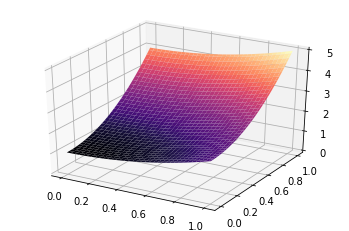

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X1, X2, zarray[:,:,frame_number], cmap="magma")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N = n_plot
nmax=20
zarray = np.zeros((n_plot, n_plot, nmax))
times= np.linspace(t_low,T,nmax)
X=np.linspace(S_low, S_high, n_plot)
mesh= np.array(np.meshgrid(X,X)).T.reshape(-1,2)
X1,X2=np.meshgrid(X,X)

for t in range(nmax):
    zarray[:,:,t] = Z= solucion_analitica(X1,X2,times[t],alpha,beta)

plot = [ax.plot_surface(X1, X2, zarray[:,:,0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,5)
animate = animation.FuncAnimation(fig, update_plot, nmax, fargs=(zarray, plot))
plt.show()

# Save as GIF
animate.save('sol_ana.gif', writer='pillow', fps=60)


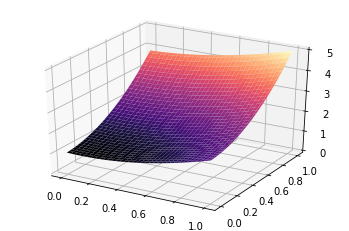

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X1, X2, zarray[:,:,frame_number], cmap="magma")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N = n_plot
nmax=20
zarray = np.zeros((n_plot, n_plot, nmax))
times= np.linspace(t_low,T,nmax)
X=np.linspace(S_low, S_high, n_plot)
mesh= np.array(np.meshgrid(X,X)).T.reshape(-1,2)
X1,X2=np.meshgrid(X,X)


for t in range(nmax):
    t_plot = times[t] * np.ones_like(mesh[:,0].reshape((-1,1)))
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:mesh})
    for j in range(n_plot):
      if j==0:
        Z_net=fitted_optionValue[0][0:n_plot]
      else:
        Z_net= np.concatenate([Z_net,fitted_optionValue[0][n_plot*j:n_plot*(j+1)].reshape((-1,1))],axis=1)
    zarray[:,:,t] = Z_net

plot = [ax.plot_surface(X1, X2, zarray[:,:,0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,5)
animate = animation.FuncAnimation(fig, update_plot, nmax, fargs=(zarray, plot))
plt.show()

# Save as GIF
animate.save('sol_rnn.gif', writer='pillow', fps=60)


<Figure size 432x288 with 0 Axes>

<Figure size 864x720 with 0 Axes>

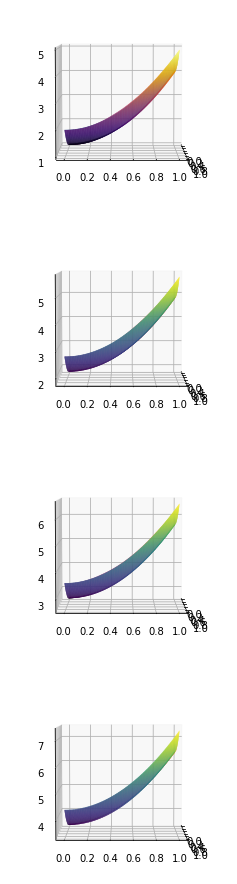

In [ ]:
#%% Plot results

# figure options
plt.figure()
plt.figure(figsize = (12,10))

# time values at which to examine density
valueTimes = [t_low, T/3, 2*T/3, T]

# vector of t and S values for plotting
X=np.linspace(S_low, S_high, n_plot)
mesh= np.array(np.meshgrid(X,X)).T.reshape(-1,2)
X1,X2=np.meshgrid(X,X)


fig = plt.figure(figsize=plt.figaspect(10))

for i, curr_t in enumerate(valueTimes):
    
    # specify subplot
    # simulate process at current t 
    Z= solucion_analitica(X1,X2,curr_t,alpha,beta)
    
    # compute normalized density at all x values to plot and current t value
    t_plot = curr_t * np.ones_like(mesh[:,0].reshape((-1,1)))
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:mesh})
    for j in range(n_plot):
      if j==0:
        Z_net=fitted_optionValue[0][0:n_plot]
      else:
        Z_net= np.concatenate([Z_net,fitted_optionValue[0][n_plot*j:n_plot*(j+1)].reshape((-1,1))],axis=1)
        
    # plot histogram of simulated process values and overlay estimated density
    ax = fig.add_subplot(4, 1, i+1, projection='3d')
    a= ax.plot_surface(X1, X2 ,Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    #ax.legend([a], ['Lyapunov function on XY plane'], numpoints = 1)
    ax.plot_surface(X1, X2 ,Z_net, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
    ax.view_init(5, 0)
    

plt.show()


In [ ]:
#%% Plot results

# figure options
fig = make_subplots(rows=4, cols=2,specs=[ [{'type': 'surface'}, {'type': 'surface'}], [{'type': 'surface'}, {'type': 'surface'}],[{'type': 'surface'}, {'type': 'surface'}],[{'type': 'surface'}, {'type': 'surface'}]      ] )


# time values at which to examine density
valueTimes = [t_low, T/3, 2*T/3, T]

# vector of t and S values for plotting
X=np.linspace(S_low, S_high, n_plot)
mesh= np.array(np.meshgrid(X,X)).T.reshape(-1,2)
X1,X2=np.meshgrid(X,X)



for i, curr_t in enumerate(valueTimes):
    
    # specify subplot
    # simulate process at current t 
    Z= solucion_analitica(X1,X2,curr_t,alpha,beta)
    
    # compute normalized density at all x values to plot and current t value
    t_plot = curr_t * np.ones_like(mesh[:,0].reshape((-1,1)))
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:mesh})
    for j in range(n_plot):
      if j==0:
        Z_net=fitted_optionValue[0][0:n_plot]
      else:
        Z_net= np.concatenate([Z_net,fitted_optionValue[0][n_plot*j:n_plot*(j+1)].reshape((-1,1))],axis=1)     
   
    fig.add_trace(go.Surface(z=Z, x=X1,y=X2, showscale=False),row=i+1, col=1)

    fig.add_trace(go.Surface(z=Z_net, x=X1,y=X2, showscale=False),row=i+1, col=2)
    
fig.update_layout(height=800, width=800, title_text="Solución analitica - Red Neuronal")
fig.show()

In [ ]:
# time values at which to examine density

RMSE_i=0 #interior
sup_i=0
RMSE_f=0 #frontera
sup_f=0
RMSE_0=0
sup_0=0

for epoch in range(len(X_train)):
  #dominio
  Z= solucion_analitica(X_train[epoch][1][:,0].reshape(-1,1),X_train[epoch][1][:,1].reshape(-1,1),X_train[epoch][0],alpha,beta)


  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][0], S_interior_tnsr:X_train[epoch][1]})
  RMSE_i+=mean_squared_error(Z, fitted_optionValue[0])
  sup_i_= np.max(abs(np.array(Z)-np.array(fitted_optionValue[0])))
  if sup_i<sup_i_:
    sup_i= sup_i_

  #frontera
  Z= solucion_borde(X_train[epoch][3][:,0].reshape(-1,1),X_train[epoch][3][:,1].reshape(-1,1),X_train[epoch][2],alpha,beta)


  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][2], S_interior_tnsr:X_train[epoch][3]})
  RMSE_f+=mean_squared_error(Z, fitted_optionValue[0])
  sup_f_= np.max(abs(np.array(Z)-np.array(fitted_optionValue[0])))
  if sup_f<sup_f_:
    sup_f= sup_f_
  #inicial
  Z= solucion_inical(X_train[epoch][5][:,0].reshape(-1,1),X_train[epoch][5][:,1].reshape(-1,1),alpha)
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][4], S_interior_tnsr:X_train[epoch][5]})
  RMSE_0+=mean_squared_error(Z, fitted_optionValue[0])
  sup_0_= np.max(abs(np.array(Z)-np.array(fitted_optionValue[0])))
  if sup_0<sup_0_:
    sup_0= sup_0_


print("L2")
print(RMSE_i/len(X_train))
print(RMSE_f/len(X_train))
print(RMSE_0/len(X_train))
print("L inf")
print(sup_i)
print(sup_f)
print(sup_0)

L2
0.002606712192712196
0.0026553278753501755
0.0024620479844181986
L inf
0.38224112974449653
0.23979981103973813
0.23119576069319514


#### adaptativo

In [ ]:
# time values at which to examine density

RMSE_i=0 #interior
sup_i=0
RMSE_f=0 #frontera
sup_f=0
RMSE_0=0
sup_0=0

for epoch in range(len(X_train)):
  #dominio
  Z= solucion_analitica(X_train[epoch][1][:,0].reshape(-1,1),X_train[epoch][1][:,1].reshape(-1,1),X_train[epoch][0],alpha,beta)


  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][0], S_interior_tnsr:X_train[epoch][1]})
  RMSE_i+=mean_squared_error(Z, fitted_optionValue[0])
  sup_i_= np.max(abs(np.array(Z)-np.array(fitted_optionValue[0])))
  if sup_i<sup_i_:
    sup_i= sup_i_

  #frontera
  Z= solucion_borde(X_train[epoch][3][:,0].reshape(-1,1),X_train[epoch][3][:,1].reshape(-1,1),X_train[epoch][2],alpha,beta)


  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][2], S_interior_tnsr:X_train[epoch][3]})
  RMSE_f+=mean_squared_error(Z, fitted_optionValue[0])
  sup_f_= np.max(abs(np.array(Z)-np.array(fitted_optionValue[0])))
  if sup_f<sup_f_:
    sup_f= sup_f_
  #inicial
  Z= solucion_inical(X_train[epoch][5][:,0].reshape(-1,1),X_train[epoch][5][:,1].reshape(-1,1),alpha)
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][4], S_interior_tnsr:X_train[epoch][5]})
  RMSE_0+=mean_squared_error(Z, fitted_optionValue[0])
  sup_0_= np.max(abs(np.array(Z)-np.array(fitted_optionValue[0])))
  if sup_0<sup_0_:
    sup_0= sup_0_


print("L2")
print(RMSE_i/len(X_train))
print(RMSE_f/len(X_train))
print(RMSE_0/len(X_train))
print("L inf")
print(sup_i)
print(sup_f)
print(sup_0)

L2
0.0007351638249932326
0.00011897866056921791
0.0002534386383509999
L inf
0.08181449264564744
0.046093369064180045
0.040027134850764146


# Wave Equation with Dirichlet Boundary Conditions 2D

https://datascience.ch/deepsphere-a-neural-network-architecture-for-spherical-data/

## Setup de la ecuación

https://en.wikipedia.org/wiki/Bessel_function#Bessel_functions_of_the_first_kind

https://docs.scipy.org/doc/scipy/reference/special.html

$\frac{\partial^{2} u}{\partial t^{2}}=c^{2}\left(\frac{\partial^{2} u}{\partial x^{2}}+\frac{\partial^{2} u}{\partial y^{2}}\right)$ 

con $\Omega=\left\{(x, y) \mid x^{2}+y^{2} \leq 1\right\}$

$$
u(x, y, t)=0, \quad \forall(x, y) \in \partial \Omega
$$
$$
\begin{aligned}
&u(x, y, 0)=J_{0}\left(\lambda_{4} \sqrt{x^{2}+y^{2}}\right), \quad \forall(x, y) \in \Omega \\
&\frac{\partial u}{\partial t}(x, y, 0)=0, \quad \forall(x, y) \in \Omega
\end{aligned}
$$


where $J_{0}(\cdot)$ represents a Bessel function of the first kind, defined as,
$$
J_{0}(r)=\sum_{m=0}^{\infty} \frac{(-1)^{m}}{(m !)^{2}}\left(\frac{r}{2}\right)^{2 m}
$$
and $\lambda_{4}$ represents the 4 th zero of $J_{0}(\cdot)$

$u(x, y, t)=J_{0}\left(\lambda_{4} \sqrt{x^{2}+y^{2}}\right) \cos \left(c \lambda_{4} t\right)$

esta mal? no coinciden en t=2



 https://www.wolframalpha.com/input/?i2d=true&i=plot+BesselJ%5C%2891%290%5C%2844%29%5C%2840%2911.791534439014281%5C%2841%29*sqrt%5C%2840%29x**2%2By**2%5C%2841%29%5C%2893%29*cos%5C%2840%292*%5C%2840%2911.791534439014281%5C%2841%29*2%5C%2841%29


$J_0$

In [ ]:
sc.j0(0)

1.0

In [ ]:
sc.jv(0, 0) 

1.0

$\lambda_4$

In [ ]:
sc.jn_zeros(0, 4)

array([ 2.40482556,  5.52007811,  8.65372791, 11.79153444])

In [ ]:
sc.jn_zeros(0, 4)
l4= sc.jn_zeros(0, 4)[3]

casi cero..

In [ ]:
sc.j0(l4)

-2.6481984375475295e-16

In [ ]:
c=2
def sol_analitica(x,y,t):
  return sc.j0(l4* np.sqrt(x**2+y**2) )*np.cos(c*l4*t)

In [ ]:
T=3
# Solution parameters (domain on which to solve PDE)
t_low = 0 + 1e-10    # time lower bound
r_low = 0.0 + 1e-10  # spot price lower bound
r_high = 1       # spot price upper bound

# neural network parameters
num_layers = 3
nodes_per_layer = 50
learning_rate = 0.1

# Training parameters
sampling_stages  = 15   # number of times to resample new time-space domain points
steps_per_sample = 50    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_interior = 1000
nSim_boundary = 1000
# Plot options
n_plot = 100  # Points on plot grid for each dimension

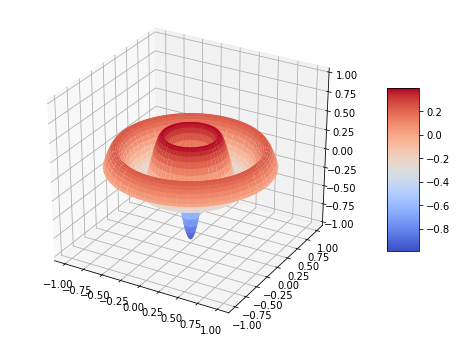

In [ ]:

n_plot=100
r = np.linspace(0, 1, n_plot) 
theta = np.linspace(0, 2*np.pi, n_plot) #angulo
theta_grid, r_grid=np.meshgrid(theta, r)

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
x_grid = r_grid*np.cos(theta_grid)
y_grid = r_grid*np.sin(theta_grid)
surf = ax.plot_surface(x_grid, y_grid, sol_analitica(x_grid,y_grid,2) ,cmap=cm.coolwarm )
ax.set_zlim(-1.01, 1.01)
# Add a color bar which maps values to colors.
fig.colorbar(surf,shrink=0.5, aspect=5)

In [ ]:
fig = go.Figure(data=[go.Surface(z=sol_analitica(x_grid,y_grid,2), x=x_grid,y=y_grid)])

fig.update_layout(title='Mt Bruno Elevation', autosize=False,width=500, height=500,margin=dict(l=65, r=50, b=65, t=90))

fig.show()

## Muestreo

In [ ]:

def sampler_radial(nSim_interior,nSim_boundary):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at terminal time to sample (terminal condition)
    ''' 
    
    # Sampler #1: domain interior
    t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
    #length = np.random.uniform(r_low, r_high*S_multiplier, size= [nSim_interior,1])
    angle = np.pi * np.random.uniform(0, 2,size= [nSim_interior,1])
    #x = np.sqrt(length) * np.cos(angle)
    #y = np.sqrt(length) * np.sin(angle)
    length= np.ones((nSim_interior, 1))* np.random.uniform(0,1)
    x = np.sqrt(length) * np.cos(angle[:nSim_interior])
    y = np.sqrt(length) * np.sin(angle[:nSim_interior])
    S_interior= np.concatenate([x,y],axis=1)

    # Sampler #2: spatial boundary
    r_1=np.ones((nSim_boundary, 1))
    x_1 = np.sqrt(r_1) * np.cos(angle[:nSim_boundary])
    y_1 = np.sqrt(r_1) * np.sin(angle[:nSim_boundary])
    S_boundary= np.concatenate([x_1,y_1],axis=1)
    # Sampler #3: initial/terminal condition
    t_terminal = np.zeros((nSim_boundary, 1))
    
    return t_interior, S_interior, t_terminal, S_boundary, t_terminal


In [ ]:
muestreo= pd.DataFrame(columns=["tiempo","x","y","region","epoca"])
# for each sampling stage
c=0
for j in range(3):
    
    # sample uniformly from the required regions
    t_interior, S_interior, t_boundary, S_boundary, t_terminal = sampler_radial(nSim_interior, nSim_boundary)
    for i in range(int(nSim_interior/2)):
      muestreo.loc[c]= [t_interior[i][0], S_interior[i,0], S_interior[i,1], "interior", j]
      c+=1
    for i in range(int(nSim_boundary/2)):
      muestreo.loc[c]= [t_boundary[i][0], S_boundary[i,0], S_boundary[i,1], "frontera", j]
      c+=1

    for i in range(int(nSim_boundary/2)):
      muestreo.loc[c]= [t_terminal[i][0], S_interior[i,0], S_interior[i,1], "inicial", j]
      c+=1
    for i in range(int(nSim_boundary/2)):
      muestreo.loc[c]= [t_terminal[i][0], S_interior[i,0], S_interior[i,1], "derivada inicial", j]
      c+=1


In [ ]:
px.scatter(muestreo, x="x", y="y", animation_frame="epoca", color="region",hover_name="region", range_x=[-2,2], range_y=[-2,2])

In [ ]:
muestreo= pd.DataFrame(columns=["tiempo","x","y","region","epoca"])
# for each sampling stage
c=0
for j in range(3):
    
    # sample uniformly from the required regions
    t_interior, S_interior, t_boundary, S_boundary, t_terminal = sampler_radial(nSim_interior, nSim_boundary)
    for i in range(int(nSim_interior/2)):
      muestreo.loc[c]= [t_interior[i][0], S_interior[i,0], S_interior[i,1], "interior", j]
      c+=1
    for i in range(int(nSim_boundary/2)):
      muestreo.loc[c]= [t_boundary[i][0], S_boundary[i,0], S_boundary[i,1], "frontera", j]
      c+=1

    for i in range(int(nSim_boundary/2)):
      muestreo.loc[c]= [t_terminal[i][0], S_interior[i,0], S_interior[i,1], "inicial", j]
      c+=1
    for i in range(int(nSim_boundary/2)):
      muestreo.loc[c]= [t_terminal[i][0], S_interior[i,0], S_interior[i,1], "derivada inicial", j]
      c+=1


In [ ]:
px.scatter(muestreo, x="x", y="y", animation_frame="epoca", color="region",hover_name="region", range_x=[-2,2], range_y=[-2,2])

## Loss

In [ ]:

#%% Loss function for Fokker-Planck equation

def loss(model, t_interior, S_interior, t_boundary, S_boundary, t_terminal):
    ''' Compute total loss for training.
    
    ''' 
    
    # Loss term #1: PDE
    # compute function value and derivatives at current sampled points
    x= tf.cast(tf.reshape(S_interior[:,0],[-1,1]),tf.float32)
    y= tf.cast(tf.reshape(S_interior[:,1],[-1,1]),tf.float32)
    V = model(t_interior, x,y)
    V_t = tf.gradients(ys=V, xs=t_interior)[0]
    V_tt = tf.gradients(ys=V_t, xs=t_interior)[0]
    V_x = tf.gradients(ys=V, xs=x)[0]
    V_y= tf.gradients(ys=V, xs=y)[0]
    V_xx = tf.gradients(ys=V_x, xs=x)[0]
    V_yy = tf.gradients(ys=V_y, xs=y)[0]
    diff_V = V_tt -(c**2 )*(V_xx+V_yy)

    # compute average L2-norm of differential operator
    L1 = tf.reduce_mean(input_tensor=tf.square(diff_V)) * 1e-5
    
    # Loss term #2: boundary condition
    x_b=tf.cast(tf.reshape(S_boundary[:,0],[-1,1]),tf.float32)
    y_b=tf.cast(tf.reshape(S_boundary[:,1],[-1,1]),tf.float32)
    L2= tf.reduce_mean( input_tensor=tf.square(model(t_boundary, x_b,y_b) ) ) 
    
    # condicion de interior tambien
    V_terminal = model(t_terminal, x,y)
    arg=l4*tf.square(x**2+y**2)
    cond_int= V_terminal- tf.numpy_function(sc.j0,[arg], tf.float32)
    L3 = tf.reduce_mean(input_tensor=tf.square(cond_int)) 

    # Loss term #3: initial/terminal condition
    V_t_terminal = tf.gradients(ys=V_terminal, xs=t_terminal)[0]
    L4 = tf.reduce_mean( input_tensor=tf.square(V_t_terminal) )

    return L1,L2, L3,L4

## Entrenamiento

In [ ]:
#%% Set up network
X_train=[]
loss_por_batch=[]
# initialize DGM model (last input: space dimension = 1)
model = DGMNet(nodes_per_layer, num_layers, 2)#1

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
S_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None,2])
t_boundary_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
S_boundary_tnsr = tf.compat.v1.placeholder(tf.float32, [None,2])
t_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])

# loss 
L1_tnsr,L2_tnsr, L3_tnsr,L4_tnsr = loss(model, t_interior_tnsr, S_interior_tnsr, t_boundary_tnsr,S_boundary_tnsr,t_terminal_tnsr)
loss_tnsr = L1_tnsr + L2_tnsr+ L3_tnsr+L4_tnsr 

# option value function
V = model(t_interior_tnsr, tf.reshape(S_interior_tnsr[:,0],[-1,1]),tf.reshape(S_interior_tnsr[:,1],[-1,1]))

# set optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.compat.v1.global_variables_initializer()

# open session
sess = tf.compat.v1.Session()
sess.run(init_op)

#%% Train network
# for each sampling stage
for i in range(sampling_stages):
    
    # sample uniformly from the required regions
    t_interior, S_interior, t_boundary, S_boundary, t_terminal =sampler_radial(nSim_interior,nSim_boundary)
    X_train.append([t_interior, S_interior, t_boundary, S_boundary, t_terminal])
    # for a given sample, take the required number of SGD steps
    for _ in range(steps_per_sample):
        loss,L1,L2,L3,L4,_ = sess.run([loss_tnsr, L1_tnsr, L2_tnsr,L3_tnsr, L4_tnsr,optimizer],
                                feed_dict = {t_interior_tnsr:t_interior, S_interior_tnsr:S_interior,t_boundary_tnsr:t_boundary, S_boundary_tnsr:S_boundary, t_terminal_tnsr:t_terminal})
    
    print(loss, L1, L2, L3,L4, i)
    loss_por_batch.append((loss,L1,L2,L3,L4))


0.035096847 0.0006156829 0.013051776 0.019491807 0.001937585 0
0.0007842207 0.00025476658 0.00018529242 0.000109437366 0.0002347243 1
0.002322389 0.00017931957 0.001066396 0.0007957783 0.00028089518 2
0.00017549211 4.1286483e-05 2.9885516e-05 2.414522e-05 8.01749e-05 3
0.0019954804 4.6098106e-05 0.0008197288 0.0010473485 8.2304825e-05 4
0.014792263 0.0005229649 0.0061969175 0.007513679 0.00055870094 5
0.0025313306 0.00041808016 0.00046552063 0.0013393891 0.00030834068 6
0.0006829139 0.00017989322 0.000119221346 0.00022383861 0.00015996069 7
0.00017110776 5.5530418e-05 3.170515e-05 2.8461416e-05 5.5410786e-05 8
0.0015535118 8.470632e-05 0.00069848454 0.00062834466 0.00014197627 9
0.0004470168 0.00012871773 0.000120687655 6.930415e-05 0.00012830728 10
0.00015746443 5.2008985e-05 2.8336479e-05 3.466319e-05 4.2455777e-05 11
0.0014253826 0.00034770652 0.00071393425 0.0002525537 0.000111188034 12
0.00090257055 0.00012451471 0.0004003118 0.0001321432 0.00024560082 13
0.00231709 0.00022530863 

In [ ]:
fig = go.Figure()

x=  list(range(sampling_stages))
loss =[i[0] for i in loss_por_batch]
L1= [i[1] for i in loss_por_batch]
L2= [i[2] for i in loss_por_batch]
L3= [i[3] for i in loss_por_batch]
L4= [i[4] for i in loss_por_batch]
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=loss,
                    mode='lines',
                    name='Loss'))
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L1,
                    mode='lines',
                    name='L: op diferencial'))

fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L2,
                    mode='lines',
                    name='L: Frontera '))
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L3,
                    mode='lines',
                    name='L: inicial'))
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L4,
                    mode='lines',
                    name='L: Derivada inicial'))
fig.update_layout(title='Pérdida por épocas',
                  yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

## Evaluación

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [ ]:
#%% Plot results

fig = make_subplots(rows=4, cols=2,specs=[ [{'type': 'surface'}, {'type': 'surface'}], [{'type': 'surface'}, {'type': 'surface'}],[{'type': 'surface'}, {'type': 'surface'}],[{'type': 'surface'}, {'type': 'surface'}]      ] )

# time values at which to examine density
valueTimes = [t_low, T/3, 2*T/3, T]
n_plot=100
r = np.linspace(0, 1, n_plot) 
theta = np.linspace(0, 2*np.pi, n_plot) #angulo
#r = np.random.uniform(r_low, r_high*S_multiplier, size= [nSim_interior,1])
#theta = np.pi * np.random.uniform(0, 2,size= [nSim_interior,1])
x_nplot = np.sqrt(r) * np.cos(theta)
y_nplot = np.sqrt(r) * np.sin(theta)
mesh=  np.concatenate([x_nplot.reshape((-1,1)),y_nplot.reshape((-1,1))],axis=1)
zarray = np.zeros((n_plot, n_plot, len(valueTimes)))
for i, curr_t in enumerate(valueTimes):
    
    # specify subplot
    # simulate process at current t 
    Z= sol_analitica(x_grid,y_grid,curr_t)
    
    # compute normalized density at all x values to plot and current t value
    t_plot = curr_t * np.ones_like(mesh[:,0].reshape((-1,1)))
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:mesh})
    Z_net= np.vstack([fitted_optionValue[0].reshape(1,-1)]*n_plot)

    fig.add_trace(go.Surface(z=Z, x=x_grid,y=y_grid, showscale=False),row=i+1, col=1)

    fig.add_trace(go.Surface(z=Z_net, x=x_grid,y=y_grid, showscale=False),row=i+1, col=2)
    
    zarray[:,:,i] = fitted_optionValue[0]

fig.update_layout(height=800, width=800, title_text="Solución analitica - Red Neuronal")
fig.show()


In [ ]:
RMSE_i=[] #interior
sup_i=0
RMSE_f=[] #frontera
sup_f=0

RMSE_i0=[] #inicial
sup_i0=0
RMSE_d0=[] #d inicial
sup_d0=0


for epoch in range(len(X_train)):
    #dominio
    Z= sol_analitica(X_train[epoch][1][:,0].reshape(-1,1),X_train[epoch][1][:,1].reshape(-1,1),X_train[epoch][0])
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][0], S_interior_tnsr:X_train[epoch][1]})
    RMSE_i.append(mean_squared_error(Z, fitted_optionValue[0]))
    
    dif= np.subtract(Z.reshape(-1,1), fitted_optionValue[0]) 
    col= np.square(dif)
    sup_i_=np.max(col)
    if sup_i<sup_i_:
      sup_i= sup_i_
     # punto_sup_i=np.argmax(col)
      #espacio_sup_i= X_train[epoch][1][punto_sup_i]
      #tiempo_sup_i=X_train[epoch][0][punto_sup_i]

    #frontera
    Z= np.zeros((nSim_boundary,1))
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][2], S_interior_tnsr:X_train[epoch][3]})
    RMSE_f.append(mean_squared_error(Z, fitted_optionValue[0]))

    dif= np.subtract(Z.reshape(-1,1), fitted_optionValue[0]) 
    col= np.square(dif)
    sup_f_=np.max(col)
    if sup_f<sup_f_:
      sup_f= sup_f_
     # punto_sup_f=np.argmax(col)
      #espacio_sup_f= X_train[epoch][3][punto_sup_f]



          #inicial
    Z= sol_analitica(X_train[epoch][1][:,0].reshape(-1,1),X_train[epoch][1][:,1].reshape(-1,1),X_train[epoch][4])
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][4], S_interior_tnsr:X_train[epoch][1]})
    RMSE_i0.append(mean_squared_error(Z, fitted_optionValue[0]))
    dif= np.subtract(Z.reshape(-1,1), fitted_optionValue[0]) 
    col= np.square(dif)
    sup_i0_=np.max(col)
    if sup_i0<sup_i0_:
      sup_i0= sup_i0_
     # punto_sup_i0=np.argmax(col)
     # espacio_sup_i0= X_train[epoch][1][punto_sup_i0]

    #derivada inicial
    Z= np.zeros((nSim_boundary,1))
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][4], S_interior_tnsr:X_train[epoch][1]})
    V_t = tf.gradients(ys=Z, xs=X_train[epoch][4])[0]
    RMSE_d0+=mean_squared_error(Z, fitted_optionValue[0])
    sup_d0_= np.max(abs(np.array(Z)-np.array(fitted_optionValue[0])))
    if sup_d0<sup_d0_:
      sup_d0= sup_d0_
      
print("L2")
print(np.mean(RMSE_i))
print(np.mean(RMSE_f))

L2
0.11697465281255072
0.0005623736062676638
